# Alarm Example (PyMC3)

In [52]:
import pymc3 as pm 
import networkx as nx 
import arviz as az
import numpy as np 
import theano

import matplotlib.pyplot as plt 
%matplotlib inline

In [53]:
# conditional probabilities
burglary = np.array([0.999, 0.001])
earthquake = np.array([0.998, 0.002])

alarm = np.array([[[0.999, 0.001], [0.71, 0.29]], [[0.06, 0.94], [0.05, 0.95]]])
marycalls = np.array([[0.99, 0.01], [0.10, 0.90]])
johncalls = np.array([[0.95, 0.05], [0.10, 0.90]])

In [54]:
# create network model
net = nx.DiGraph()

net.add_node('burglary', dtype = 'Discrete', prob = burglary, pos = (2.5, 4))
net.add_node('earthquake', dtype = 'Discrete', prob = earthquake, pos = (3.5, 4))

net.add_node('alarm', dtype = 'Discrete', prob = alarm, pos = (3, 2))

net.add_node('marycalls', dtype = 'Discrete', prob = marycalls, pos = (2.5, 0))
net.add_node('johncalls', dtype = 'Discrete', prob = johncalls, pos = (3.5, 0), observed = 1)

net.add_edges_from([('burglary', 'alarm'), ('earthquake', 'alarm'), ('alarm', 'marycalls'), ('alarm', 'johncalls')])

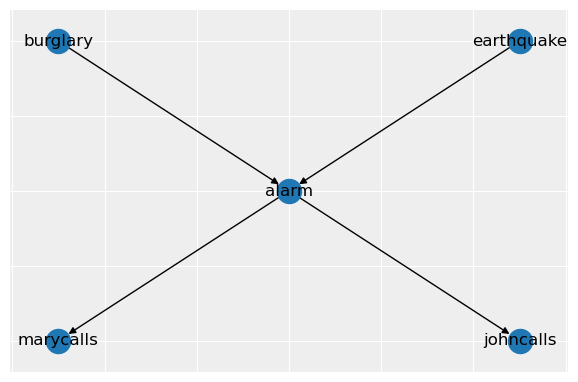

In [55]:
az.style.use('arviz-darkgrid')
nx.draw_networkx(net, pos = nx.get_node_attributes(net, 'pos'))

In [56]:
# function to get parent object
def get_parent(net, node, idx = 0):
    return net.nodes[list(net.predecessors(node))[idx]]['pm_obj']

# pymc3 model
with pm.Model() as model_alarm:
    net.nodes['burglary']['pm_obj'] = pm.Categorical('burglary', p = net.nodes['burglary']['prob'])
    net.nodes['earthquake']['pm_obj'] = pm.Categorical('earthquake', p = net.nodes['earthquake']['prob'])

    alarm_prob = theano.shared(alarm)[get_parent(net, 'alarm', 0), get_parent(net, 'alarm', 1)]
    net.nodes['alarm']['pm_obj'] = pm.Categorical('alarm', p = alarm_prob)

    marycalls_prob = theano.shared(marycalls)[get_parent(net, 'marycalls')]
    johncalls_prob = theano.shared(johncalls)[get_parent(net, 'johncalls')]

    net.nodes['marycalls']['pm_obj'] = pm.Categorical('marycalls', p = marycalls_prob)
    net.nodes['johncalls']['pm_obj'] = pm.Categorical('johncalls', p = johncalls_prob, observed = net.nodes['johncalls']['observed'])

In [57]:
# sampling
with model_alarm:
    trace = pm.sample(2000)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [burglary, earthquake, alarm, marycalls]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 3098.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [58]:
# get a summary of the result -- if John calls you, what is the probability of earthquake
az.summary(trace['earthquake'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.011,0.105,0.0,0.0,0.002,0.001,2991.0,2991.0,2991.0,2991.0,NaN


In [59]:
# save variable in the dictionary
for node in trace.varnames:
    net.nodes[node]['trace'] = trace[node]